In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import collections

In [2]:
POSITION_DEPENDENT_FEATURES = [
    'cmp', 'pass_att', 'pass_yds', 'pass_td', 'pass_int', 'rush_att', 'rush_yds', 'rush_tds', 'rec', 'rec_yds', 'rec_tds', 'tkl', 'def_int', 'sk', 
]


In [3]:
# import and preview dataset
data = pd.read_csv("nfl_draft.csv")
data.head()

,column_a,player_id,year,rnd,pick,tm,player,hof,pos,position_standard,...,rush_att,rush_yds,rush_tds,rec,rec_yds,rec_tds,tkl,def_int,sk,college_univ
0,2015Jameis Winston,WinsJa00,2015,1,1,TAM,Jameis Winston,No,QB,QB,...,86.0,311.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,Florida St.
1,2015Marcus Mariota,MariMa01,2015,1,2,TEN,Marcus Mariota,No,QB,QB,...,79.0,516.0,4.0,1.0,41.0,1.0,NaN,NaN,NaN,Oregon
2,2015Dante Fowler,FowlDa00,2015,1,3,JAX,Dante Fowler,No,OLB,LB,...,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,2.5,Florida
3,2015Amari Cooper,CoopAm00,2015,1,4,OAK,Amari Cooper,No,WR,WR,...,3.0,-3.0,0.0,134.0,1970.0,9.0,NaN,NaN,NaN,Alabama
4,2015Brandon Scherff,ScheBr00,2015,1,5,WAS,Brandon Scherff,No,T,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Iowa


In [4]:
# frequency of null entries in each feature
data.isnull().sum()

column_a                0
player_id            1219
year                    0
rnd                     0
pick                    0
tm                      0
player                  0
hof                     0
pos                     0
position_standard       0
first4av                0
age                  1245
to                   1382
ap1                     0
pb                      0
st                      0
carav                1382
drav                 2165
g                    1415
cmp                  7841
pass_att             7841
pass_yds             7841
pass_td              7841
pass_int             7841
rush_att             6789
rush_yds             6789
rush_tds             6789
rec                  6264
rec_yds              6264
rec_tds              6264
tkl                  4324
def_int              6819
sk                   4388
college_univ         3430
dtype: int64

In [5]:
#Many features have null values. We suspect that the reason is that some
#positions do not do things that other positions do. For example, a linebacker
#will likely never throw a football, so they will have null for cmp
#(completions)

#let's verify and check how many QB's have null completions vs total amount of
#null completions
null_cmps = data[data['cmp'].isnull()]
null_cmps.shape


(7841, 34)

In [6]:
null_cmps.loc[null_cmps['pos'] == 'QB'].shape

# as we can see, only 115 out the 7841 null values are QB positions
# Because of this, we think it is best to impute a value of 0 
# for the position-dependent features completions, rush attempts, touchdowns, 
# etc) 

(115, 34)

In [7]:
data[POSITION_DEPENDENT_FEATURES] = data[POSITION_DEPENDENT_FEATURES].fillna(0)
data.isnull().sum()

column_a                0
player_id            1219
year                    0
rnd                     0
pick                    0
tm                      0
player                  0
hof                     0
pos                     0
position_standard       0
first4av                0
age                  1245
to                   1382
ap1                     0
pb                      0
st                      0
carav                1382
drav                 2165
g                    1415
cmp                     0
pass_att                0
pass_yds                0
pass_td                 0
pass_int                0
rush_att                0
rush_yds                0
rush_tds                0
rec                     0
rec_yds                 0
rec_tds                 0
tkl                     0
def_int                 0
sk                      0
college_univ         3430
dtype: int64

In [8]:
data['position_standard'].value_counts()
#LS is a specialized version of C, so we can combine the two into the same position


DB    1569
LB    1124
WR    1049
RB     809
DE     731
DT     640
T      619
G      542
TE     496
QB     398
C      225
K       78
FB      77
P       77
LS       1
Name: position_standard, dtype: int64

In [9]:
data['position_standard'] = data['position_standard'].replace(['LS'], 'C')
data['position_standard'].value_counts()

DB    1569
LB    1124
WR    1049
RB     809
DE     731
DT     640
T      619
G      542
TE     496
QB     398
C      226
K       78
FB      77
P       77
Name: position_standard, dtype: int64

In [10]:
print(data['rnd'].corr(data['drav']))
print(data['rnd'].corr(data['carav']))
print(data['drav'].corr(data['carav']))


#drav and carav basically describe the same thing (career average and draft average)
#this can be seen from their correlation value
#we decided to drop drav (as will be seen later) because corr with rnd, our label, lower than carav and they are similar
data.drop(['drav'], axis=1, inplace=True)

-0.36528440711228094
-0.3756977577406549
0.8715160708472572


In [11]:
data['rnd']

0        1
1        1
2        1
3        1
4        1
        ..
8430    12
8431    12
8432    12
8433    12
8434    12
Name: rnd, Length: 8435, dtype: int64

In [12]:
def transform(x):
  if(x['year'] <= 1993): #rounds before 1993 did not have 32 rounds per pick. We should standardize to today's standard
    x['rnd'] = 1 + int(x['pick'] / 32)
  return x

data = data.apply(func=transform, axis=1, result_type='broadcast')



In [13]:
#fixing the type from object back to int64
data['rnd'] = data['rnd'].astype('int64')
data['rnd']

0        1
1        1
2        1
3        1
4        1
        ..
8430    11
8431    11
8432    11
8433    11
8434    11
Name: rnd, Length: 8435, dtype: int64

In [14]:
# use counter to get frequency of each label to view class imbalances
labels = data['rnd']
labels.value_counts()

7     1284
6     1127
4     1075
5     1063
3     1041
2      985
1      970
8      257
9      256
10     256
11     121
Name: rnd, dtype: int64

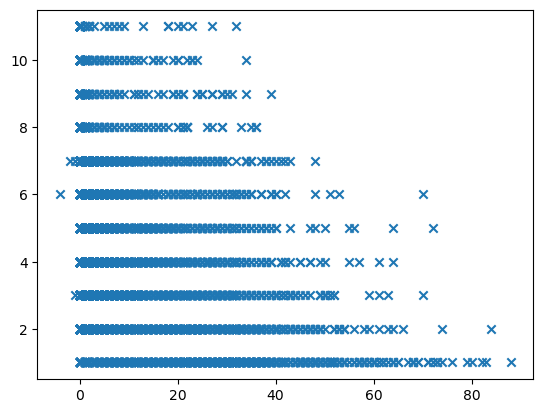

In [15]:
#we have a class imbalance so we want to bin certain labels into groups
#to decide whether to do A) 3 bins of 1-3, 4-6, and 7+ OR 
# B) 3 bins of 1-2, 3-4, 5+, we wanted to see how different players picked
#in each round of the draft were. 

#we used first4av, which is a metric that is used by colleges to quantify
#how well a player plays over their first four seasons as the differentiating factor.

#based on the plot below, the growth is more linear as opposed to players
#in the top few rounds being exponentially better than the rest of the competition
#so we chose to stick with the bin option A), which is more linear
data[['first4av', 'rnd']]
plt.scatter(x=data['first4av'], y=data['rnd'], marker='x')

In [16]:
#we want to reduce class imbalance and increase accuracy by having less labels to guess
#so we are binning them in terms of 1-3, 4-6, and 7 and above
#where 1 represents 1-3 and 4 represents 4-6 and 7 represents 7 and above
data.loc[data['rnd'] <= 3, 'rnd'] = 1
data.loc[(data['rnd'] > 3) & (data['rnd'] <= 6) , 'rnd'] = 4
data.loc[data['rnd'] > 6, 'rnd'] = 7
data['rnd'].value_counts() 

4    3265
1    2996
7    2174
Name: rnd, dtype: int64

In [17]:
#pick directly correlates with round. keeping it as a feature would be data leakage
data.drop(['pick'], axis=1, inplace=True)

In [18]:
'''
Dropping ap1 (Deals with all pro designation), pb (Deals with Pro Bowler
designation), hof (hall of fame designation)
This is future data (received after they were drafted and cannot be used in
prediction)


'''
data.drop(['ap1', 'pb', 'to'], axis=1, inplace=True)

#unneeded identifying information like name/player id, team, etc. Does not help with our prediction
data.drop(['column_a','player_id','tm', 'hof', 'player', 'age', 'year'], axis=1, inplace=True)

#dropping pos because it is the same as pos_standard but splits up positions into more specialized ones
#making it harder to group because of low value counts
data.drop(['pos'], axis=1, inplace=True)

#drop things with too many nulls that cannot be imputed
data.drop(['college_univ'], axis=1, inplace=True)

data.columns

Index(['rnd', 'position_standard', 'first4av', 'st', 'carav', 'g', 'cmp',
       'pass_att', 'pass_yds', 'pass_td', 'pass_int', 'rush_att', 'rush_yds',
       'rush_tds', 'rec', 'rec_yds', 'rec_tds', 'tkl', 'def_int', 'sk'],
      dtype='object')

In [19]:
data.isna().sum()

rnd                     0
position_standard       0
first4av                0
st                      0
carav                1382
g                    1415
cmp                     0
pass_att                0
pass_yds                0
pass_td                 0
pass_int                0
rush_att                0
rush_yds                0
rush_tds                0
rec                     0
rec_yds                 0
rec_tds                 0
tkl                     0
def_int                 0
sk                      0
dtype: int64

In [20]:
#carav and g are the only features with null values left
#we will fix them with mean imputation b/c carav is based on 
#all around stats and g stands for games played. It is assumed that people with
#stats have more than 0 games played
data['carav'].fillna(data['carav'].mean(), inplace=True)
data['g'].fillna(data['g'].mean(), inplace=True)
data.isna().sum()

rnd                  0
position_standard    0
first4av             0
st                   0
carav                0
g                    0
cmp                  0
pass_att             0
pass_yds             0
pass_td              0
pass_int             0
rush_att             0
rush_yds             0
rush_tds             0
rec                  0
rec_yds              0
rec_tds              0
tkl                  0
def_int              0
sk                   0
dtype: int64

In [21]:
#position is a string, so we are one hot encoding it so we can pass it into different models
one_hot = pd.get_dummies(data['position_standard'])
combined = pd.concat([one_hot, data], axis=1).drop(['position_standard'], axis=1)
data = combined
data.columns

Index(['C', 'DB', 'DE', 'DT', 'FB', 'G', 'K', 'LB', 'P', 'QB', 'RB', 'T', 'TE',
       'WR', 'rnd', 'first4av', 'st', 'carav', 'g', 'cmp', 'pass_att',
       'pass_yds', 'pass_td', 'pass_int', 'rush_att', 'rush_yds', 'rush_tds',
       'rec', 'rec_yds', 'rec_tds', 'tkl', 'def_int', 'sk'],
      dtype='object')

In [22]:
#for some reason, as shown below, sk - sacks - contains strings.
data[data.isin(['Washington']).any(axis=1)].head()

,C,DB,DE,DT,FB,G,K,LB,P,QB,...,pass_int,rush_att,rush_yds,rush_tds,rec,rec_yds,rec_tds,tkl,def_int,sk
5762,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,Washington
5779,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,22.0,0.0,7.0,2.0,Washington
5822,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Washington
5829,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Washington
5830,0,0,0,0,0,0,0,0,0,0,...,0.0,2.0,7.0,1.0,97.0,1029.0,5.0,0.0,0.0,Washington


In [23]:
# we can't impute the numerical value based on strings, so we will drop the column
data.drop(['sk'], axis=1, inplace=True)

In [24]:
#making sure our data is the right type
labels = labels.astype('int')

In [25]:
data.corr()
#the correlation between rnd and each of the position columns is very minimal, so we will remove the position columns to decrease noise

,C,DB,DE,DT,FB,G,K,LB,P,QB,RB,T,TE,WR,rnd,carav,g
C,1.000000,-0.079317,-0.051110,-0.047543,-0.015926,-0.043480,-0.016030,-0.065058,-0.015926,-0.036924,-0.054042,-0.046694,-0.041473,-0.062531,0.006639,0.040311,0.037422
DB,-0.079317,1.000000,-0.147252,-0.136975,-0.045883,-0.125267,-0.046183,-0.187437,-0.045883,-0.106379,-0.155699,-0.134528,-0.119486,-0.180153,-0.023572,-0.030762,0.009232
DE,-0.051110,-0.147252,1.000000,-0.088264,-0.029566,-0.080720,-0.029759,-0.120780,-0.029566,-0.068548,-0.100329,-0.086687,-0.076994,-0.116087,-0.035674,0.034087,0.027129
DT,-0.047543,-0.136975,-0.088264,1.000000,-0.027503,-0.075086,-0.027682,-0.112351,-0.027503,-0.063764,-0.093327,-0.080637,-0.071621,-0.107985,-0.005551,0.012808,0.002565
FB,-0.015926,-0.045883,-0.029566,-0.027503,1.000000,-0.025152,-0.009273,-0.037635,-0.009213,-0.021359,-0.031262,-0.027011,-0.023991,-0.036172,0.008832,-0.047353,0.026969
G,-0.043480,-0.125267,-0.080720,-0.075086,-0.025152,1.000000,-0.025316,-0.102748,-0.025152,-0.058314,-0.085350,-0.073745,-0.065499,-0.098756,0.025405,0.041390,0.008044
K,-0.016030,-0.046183,-0.029759,-0.027682,-0.009273,-0.025316,1.000000,-0.037881,-0.009273,-0.021499,-0.031466,-0.027188,-0.024148,-0.036409,0.045604,-0.009698,0.050647
LB,-0.065058,-0.187437,-0.120780,-0.112351,-0.037635,-0.102748,-0.037881,1.000000,-0.037635,-0.087255,-0.127709,-0.110344,-0.098006,-0.147767,-0.001556,0.010302,0.003232
P,-0.015926,-0.045883,-0.029566,-0.027503,-0.009213,-0.025152,-0.009273,-0.037635,1.000000,-0.021359,-0.031262,-0.027011,-0.023991,-0.036172,0.039321,-0.019452,0.050835
QB,-0.036924,-0.106379,-0.068548,-0.063764,-0.021359,-0.058314,-0.021499,-0.087255,-0.021359,1.000000,-0.072480,-0.062625,-0.055623,-0.083864,0.002005,0.040950,-0.048662


In [26]:
data.drop(['C', 'DB', 'DE', 'DT', 'FB', 'G', 'K', 'LB', 'P', 'QB', 'RB', 'T', 'TE','WR'], axis=1, inplace=True)
#these are our final columns
data.columns

Index(['rnd', 'first4av', 'st', 'carav', 'g', 'cmp', 'pass_att', 'pass_yds',
       'pass_td', 'pass_int', 'rush_att', 'rush_yds', 'rush_tds', 'rec',
       'rec_yds', 'rec_tds', 'tkl', 'def_int'],
      dtype='object')

In [27]:
features = data.drop(['rnd'], axis=1)
labels = data['rnd']
features.columns

Index(['first4av', 'st', 'carav', 'g', 'cmp', 'pass_att', 'pass_yds',
       'pass_td', 'pass_int', 'rush_att', 'rush_yds', 'rush_tds', 'rec',
       'rec_yds', 'rec_tds', 'tkl', 'def_int'],
      dtype='object')

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#gaussian
gaussian = GaussianNB()
g_predicts = cross_val_predict(gaussian, features, labels, cv=5)

#decision tree
d_clf = DecisionTreeClassifier()
d_params = {"max_depth": [5,10,15,20], "min_samples_leaf": [5,10,15,20]}
d_grid_search = GridSearchCV(d_clf, d_params, cv=5, scoring='accuracy') #inner loop
d_predicts = cross_val_predict(d_grid_search, features, labels, cv=5)

#neural nets
n_pipe = Pipeline([('scaler', StandardScaler()), ('MLP', MLPClassifier())])
n_param_grid = {
    'MLP__hidden_layer_sizes': list(range(30, 70, 10)),
    'MLP__activation': ['logistic', 'tanh', 'relu']
}
n_grid_search = GridSearchCV(n_pipe, n_param_grid, cv=5)
n_predicts = cross_val_predict(n_grid_search, features, labels, cv=5)

#ada boost
a_clf = AdaBoostClassifier()
a_params = {"n_estimators": [50,100,150]}
a_grid_search = GridSearchCV(a_clf, a_params, cv=5)
a_predicts = cross_val_predict(a_grid_search, features, labels, cv=5)

#svc
s_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('svc', SVC())])
s_param_grid = {
    'pca__n_components': list(range(5, 15)),
    'svc__kernel': ['linear', 'rbf', 'poly']
}
s_grid_search = GridSearchCV(s_pipe, s_param_grid, cv=5)
s_predicts = cross_val_predict(s_grid_search, features, labels, cv=5)

#knn
k_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('KNN', KNeighborsClassifier())])
k_param_grid = {
    'pca__n_components': list(range(5, 15)),
    'KNN__n_neighbors': list(range(1, 25))
}
k_grid_search = GridSearchCV(k_pipe, k_param_grid, cv=5)
k_predicts = cross_val_predict(k_grid_search, features, labels, cv=5)
print('done')
#take all predicts and do something

In [29]:
import numpy as np
from scipy import stats
all_predicts = np.stack([g_predicts, d_predicts, n_predicts, a_predicts, s_predicts, k_predicts])
most_common = stats.mode(all_predicts)[0]
num_correct = (most_common.flatten() == labels).sum()
ensemble_accuracy = num_correct / len(labels)
print("Ensemble accuracy:", ensemble_accuracy)

Ensemble accuracy: 0.5599288678126852


C:\Users\lawso\AppData\Local\Temp\ipykernel_11940\3225834700.py:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  most_common = stats.mode(all_predicts)[0]


In [30]:
from sklearn.metrics import classification_report
names = ['Naive Bayes', 'Decision Tree', 'Neural Net', 'Ada Boost', 'SVM', 'KNN']
for p, n in zip(all_predicts, names) :
    print(n, ":\n", classification_report(labels, p))

Naive Bayes :
               precision    recall  f1-score   support

           1       0.74      0.32      0.45      2996
           4       0.31      0.11      0.16      3265
           7       0.33      0.91      0.48      2174

    accuracy                           0.39      8435
   macro avg       0.46      0.45      0.36      8435
weighted avg       0.47      0.39      0.35      8435

Decision Tree :
               precision    recall  f1-score   support

           1       0.64      0.59      0.61      2996
           4       0.47      0.60      0.53      3265
           7       0.56      0.40      0.47      2174

    accuracy                           0.55      8435
   macro avg       0.56      0.53      0.54      8435
weighted avg       0.56      0.55      0.54      8435

Neural Net :
               precision    recall  f1-score   support

           1       0.65      0.63      0.64      2996
           4       0.48      0.60      0.53      3265
           7       0.56      

Conclusion:

A significant amount of data cleaning and feature engineering was needed for this. The data set had many NaN values that needed to be imputed in different ways depending on the feature. In addition, there were many features that were unneeded or provided information from the future. In order to have the best data for our models, we decided to remove these. While future information would have greatly improved the accuracy of our models, real-world data on college NFL stats does not have things like their future team if they have not yet been drafted. Next, we had to change the class labels from numbers into bins. With the number of rounds we have, it is not feasible with the amount of time or expertise we have to create a model that has good accuracy on 11+ classes. So, we decided to bin the classes into 3 bins. This allows for our models to have a higher accuracy as they don't need to be extremely precise. Finally, we also had to change the number of classes (rounds) as prior to 1993, there were a different number of rounds per pick. Thus, we had to standardize the data to today's standard of 32 picks per round and 7 rounds per draft.

All of our models except for Naive Bayes had around the same accuracy (50-56%). However, the highest was SVC at 0.56. We can compare this to the rate of guessing randomly, which will give you a 33% accuracy rate. So, our best model gives a 169% increase over randomly guessing.

The amount of time we spent data cleaning made up the majority of our work, which was reflective of what a lot of data scientists do on the job. At the same time, we think the majority of our models would be good to gain insights about future drafts, assuming that our stakeholders are okay with the classes being put into bins.